# Plant Seedlings Classification

https://www.kaggle.com/c/plant-seedlings-classification/data

Determine the species of a seedling from an image

## 1. Load Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [38]:
tf.keras.backend.clear_session()

In [3]:
data_dir = pathlib.Path('/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification')
image_count = len(list(data_dir.glob('train/*/*.png')))

In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=360,
        validation_split=0.2)
train_dir = '/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification/train'
classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet']

train_data_gen = image_generator.flow_from_directory(directory=train_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = classes,
                                                     subset="training")

valid_data_gen = image_generator.flow_from_directory(directory=train_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = classes,
                                                     subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


## 2. Create Model

### 2.1 Convolutional Neural Net

In [37]:
model_v1 = keras.Sequential()

model_v1.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.BatchNormalization())
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.BatchNormalization())
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.BatchNormalization())
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.BatchNormalization())
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Flatten())

model_v1.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model_v1.add(keras.layers.Dropout(0.1))

model_v1.add(keras.layers.Dense(12, activation='softmax'))

model_v1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 111, 111, 64)      256       
_________________________________________________________________
dropout_18 (Dropout)         (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 54, 54, 128)      

### 2.2 Resnet with pretrained weights on ImageNet

In [ ]:
base_model_resnet = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                                               include_top=False,
                                               weights='imagenet')

In [10]:
base_model_resnet.trainable = True

for layer in base_model_resnet.layers[:150]:
  layer.trainable = False

len(base_model_resnet.layers)

# base_model_resnet.summary()

175

In [11]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
classification_layer = keras.layers.Dense(12, activation='softmax', kernel_regularizer= keras.regularizers.l2(0.001))
dropout_layer = keras.layers.Dropout(0.5)

In [12]:
model_v2 = tf.keras.Sequential([
  base_model_resnet,
  global_average_layer,
  dropout_layer,
  classification_layer
])

In [13]:
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24588     
Total params: 23,612,300
Trainable params: 23,559,180
Non-trainable params: 53,120
_________________________________________________________________


## 3. Train Model

In [ ]:
model_v1.load_weights('./checkpoints/checkpoint_m1_1')

In [7]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [39]:
model_v1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
model_v1_history = model_v1.fit(train_data_gen, epochs=30, steps_per_epoch=None, validation_data=valid_data_gen)

Train for 119 steps, validate for 30 steps
Epoch 1/30
119/119 [==============================] - 133s 1s/step - loss: 3.9872 - accuracy: 0.2882 - val_loss: 13.5777 - val_accuracy: 0.0507
Epoch 2/30
119/119 [==============================] - 129s 1s/step - loss: 2.5504 - accuracy: 0.3747 - val_loss: 16.0254 - val_accuracy: 0.1288
Epoch 3/30
119/119 [==============================] - 128s 1s/step - loss: 2.2834 - accuracy: 0.4326 - val_loss: 3.2582 - val_accuracy: 0.2154
Epoch 4/30
119/119 [==============================] - 126s 1s/step - loss: 1.9733 - accuracy: 0.4846 - val_loss: 3.7578 - val_accuracy: 0.3442
Epoch 5/30
119/119 [==============================] - 127s 1s/step - loss: 1.7445 - accuracy: 0.5080 - val_loss: 2.3100 - val_accuracy: 0.4393
Epoch 6/30
119/119 [==============================] - 130s 1s/step - loss: 1.5548 - accuracy: 0.5475 - val_loss: 1.5632 - val_accuracy: 0.5787
Epoch 7/30
119/119 [==============================] - 130s 1s/step - loss: 1.4134 - accuracy: 0.5

In [44]:
model_v1.save_weights('./checkpoints/checkpoint_m1_1')

### 3.2 Training with ResNet50

Is not feasible to use RestNet50 based on the lack of data. The model greatly overfit.

In [15]:
model_v2.compile(optimizer=get_optimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_v2_history = model_v2.fit(train_data_gen, epochs=10, steps_per_epoch=None, validation_data=valid_data_gen)

## 4. Evaluate on Test Data

### 4.1 Predicting with Basic Convolutional Neural Net

Received score of 0.78085 on Kaggle competition data.

In [45]:
test_dir = '/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification/'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_directory(directory=test_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = ['test'])

Found 794 images belonging to 1 classes.


In [46]:
pred = model_v1.predict(
    test_data_gen, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False,
)

In [47]:
y = np.argmax(pred, axis=1)

In [48]:
predicted_classes = [classes[i] for i in y]
files = [path[5:] for path in test_data_gen.filenames]

In [49]:
subm = np.stack([files,predicted_classes], axis=1)
np.savetxt('submission.csv', subm, fmt='%s,%s', header='file,species', comments='')

## 5. Analysis

### 5.1 Analysis of Basic Convolutional Neural Net

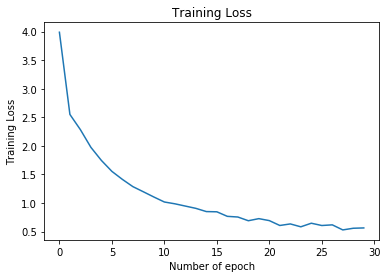

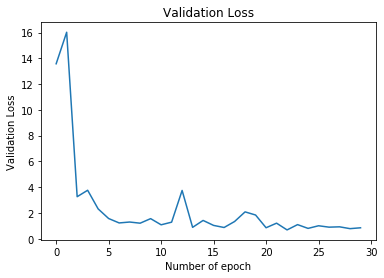

In [50]:
epochs = range(0, len(model_v1_history.history['loss']))
training_loss = model_v1_history.history['loss']
validation_loss = model_v1_history.history['val_loss']

# training loss 
plt.plot(epochs, training_loss)
plt.xlabel("Number of epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

# validation loss
plt.plot(epochs , validation_loss)
plt.xlabel("Number of epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
plt.show()